In [17]:
import numpy as np
import pandas as pd
import requests
import os
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier, LGBMRegressor



#Personal Header
headers = {'user-agent': 'Muhurto Personal Project (bur6yx@virginia.edu)'}

#Profile Id for Valorant
profileid = "Muhurto#7071"

r = requests.get(f"https://u.gg/val/profile/{profileid}", headers = headers)




In [18]:
# This cell takes approximately 5 minutes to run

service = Service(executable_path="chromedriver.exe")
driver = webdriver.Chrome(service = service)

driver.get(f"https://u.gg/val/profile/{profileid.replace(" ","%20").replace("#","-")}")

time.sleep(7)

while True:
    try:
        input_element = driver.find_element(By.CSS_SELECTOR,
                                            ".flex.items-center.justify-center.group.rounded-sm.px-4.py-2\\.5.text-\\[13px\\].font-bold.dark\\:bg-lavender-500.dark\\:hover\\:bg-lavender-600.dark\\:text-white.dark\\:ui-toggled\\:bg-lavender-500.dark\\:ui-toggled\\:font-bold.leading-none")
        input_element.click()
    except Exception as e:
        print("No More Matches to Load", e)
        break

time.sleep(7)

match_buttons = driver.find_elements(By.CSS_SELECTOR,
                                     ".flex.flex-col.justify-around.select-none.w-full")
for i in match_buttons:
    try:
        i.click()
        time.sleep(1)
    except Exception as e:
        print(f"Error occured while clicking on a button{e}")

page_source = driver.page_source

driver.quit()


KeyboardInterrupt: 

In [5]:
soup = BeautifulSoup(page_source,"html")
defeats = soup.find_all("span", class_ = 'dark:text-accent-red-500 inline-block mr-2 text-md font-bold leading-[17px]')
victories = soup.find_all("span", class_ = "dark:text-accent-green-300 inline-block mr-2 text-md font-bold leading-[17px]")
matches = soup.find_all("div", class_ = "flex flex-col justify-around select-none w-full")

#Just iterate this first number to scrape through and work with all the information here


playedagents = []
roundswon = []
roundslost = []
numkills = []
numdeaths = []
numassists = []
accuracy = []
mapplayed = []
acs = []
rank = []
relativerank = []


for i in range(len(matches)):
    #Played Agents works for the first 20 matches!
    playedagents.append(matches[i].find_all("div", class_ = "flex items-center mr-3")[0].find("span").attrs['class'][-1].split("-")[-1])
    roundswon.append(matches[i].find_all("div", class_ = "font-bold text-sm")[0].find_all("span")[0].text)
    roundslost.append(matches[i].find_all("div", class_ = "font-bold text-sm")[0].find_all("span")[2].text)
    numkills.append(matches[i].find_all("div", class_ = "dark:text-lavender-300")[0].find_all("span")[0].text)
    numdeaths.append(matches[i].find_all("div", class_ = "dark:text-lavender-300")[0].find_all("span")[1].text)
    numassists.append(matches[i].find_all("div", class_ = "dark:text-lavender-300")[0].find_all("span")[2].text)
    mapplayed.append(matches[i].find_all("div", class_= "flex items-center xs:relative w-full xs:w-[100px] h-full bg-contain bg-center rounded-sm")[0].text)
    acs.append(matches[i].find_all("div", class_ = "text-xxs dark:text-lavender-50")[0].text.split()[0])
    relativerank.append(matches[i].find_all("div", class_ = "flex flex-col h-full justify-between items-center text-xs xs:ml-5")[0].find_all("span")[3].text)
    rank.append(matches[i].find_all("div", class_ = "flex items-center nowrap whitespace-nowrap")[0].text)
    accuracy.append(matches[i].find_all("div", class_ = "flex items-center font-semibold text-xs")[0].text)
    # Same weird thing with map, the span background is a little different. 

pdata = pd.DataFrame(
    {
        "Agent": playedagents,
        "RoundWins": roundswon,
        "RoundLosses": roundslost,
        "Kills": numkills,
        "Deaths": numdeaths,
        "Assists": numassists,
        "Accuracy": accuracy,
        "Map": mapplayed,
        "CombatScore": acs,
        "MatchRank": relativerank,
        "CompetitiveRank": rank
    }
)
pdata

,Agent,RoundWins,RoundLosses,Kills,Deaths,Assists,Accuracy,Map,CombatScore,MatchRank,CompetitiveRank


## Agent Prediction Picker

In [ ]:

matchinfo = soup.find_all("table", class_ = "w-full dark:bg-purple-400")

agentsonteam = []

# Iterate through list of all possible tables containing player information
for i in matchinfo:
    playerlist = i.tbody.find_all("tr")
    teammatelist = []
    enemylist = []
    for j in playerlist:
        if "dark:bg-accent-red-5" in j.attrs['class'][0].split("0"):
            enemylist.append(j)
        else:
            teammatelist.append(j)
    
    #Okay I might need to remove this later but for now I think it's okay to include myself in the team comp
    '''
    for i in teammatelist:
        if i.find_all("span", class_ = "text-ellipsis overflow-hidden whitespace-nowrap text-nowrap md:max-w-[80%]")[0].text == profileid.split("#")[0]:
            teammatelist.remove(i)
    '''
    #for i in teammatelist:
        #print(i.find_all("span", class_ = "text-ellipsis overflow-hidden whitespace-nowrap text-nowrap md:max-w-[80%]")[0].text)
    # Interestingly, my code doesn't scrape the most recent game for teammates and non-teammates.
    # This might be because padding is different?
    # It doesn't register the first row, but everything else works out perfectly. 
    for i in teammatelist:
        agentsonteam.append(i.a.next.attrs['class'][-1].split("-")[-1])

# Rough outline for my predictive model dataframe - 
# I want my current comp rank, team composition,
# the number of points I won by, 
# and the binary column of victory. 

teamdf = pdata.iloc[1:250,].reset_index()


valorantagents = ["brimstone",'phoenix','sage','sova',
                  'viper','cypher','reyna','killjoy',
                  'breach','omen','jett','raze',
                  'skye','yoru','astra','kayo',
                  'chamber','neon','fade','harbor',
                  'gekko','deadlock','iso','clove',
                  'vyse']


#Change data types to numeric
changenumeric = ['RoundWins','RoundLosses','Kills','Deaths','Assists']
for i in changenumeric:
    teamdf[i] = teamdf[i].astype(float)



#Right now we are counting ties as defeats for model simplicity, might try to predict on delta points to account for this
for i in valorantagents:
    teamdf[i] = np.zeros(249).tolist()
teamdf["Victory"] = np.where(teamdf["RoundWins"] > teamdf["RoundLosses"],1,0)

teamdf["DeltaScore"] = teamdf["RoundWins"] - teamdf["RoundLosses"]


#Now we group our long agent list into groups of 4 (4 other players on our team), so they align with each round
agentsonteam = [agentsonteam[i:i+5] for i in range(0,len(agentsonteam),5)]

# Nested loop structure just goes row by row on the dataframe, assigning agents to thier corresponding 
# column values if the value of the agent name matches the agent column 
for i,j in enumerate(agentsonteam):
    for k in j:
        if k in teamdf.columns:
            teamdf.loc[i,k] = 1
relevantcolumns = ["brimstone",'phoenix','sage','sova',
                  'viper','cypher','reyna','killjoy',
                  'breach','omen','jett','raze',
                  'skye','yoru','astra','kayo',
                  'chamber','neon','fade','harbor',
                  'gekko','deadlock','iso','clove',
                  'vyse','Victory','DeltaScore','Map']

modeldf = pd.DataFrame()

for i in relevantcolumns:
    modeldf[i] = teamdf[i]
modeldf

,brimstone,phoenix,sage,sova,viper,cypher,reyna,killjoy,breach,omen,...,fade,harbor,gekko,deadlock,iso,clove,vyse,Victory,DeltaScore,Map
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN


### It might be smart to pre-process by role rather than agent to reduce dimensionality

In [7]:
# These are the official valorant agent roles
modeldf['Duelist'] = modeldf[['jett','phoenix','yoru','neon','raze','reyna','iso']].sum(axis = 1)
modeldf['Controller'] = modeldf[['brimstone','viper','omen','harbor','astra','clove']].sum(axis = 1)
modeldf['Initiator'] = modeldf[['sova','breach','skye','kayo','fade','gekko']].sum(axis = 1)
modeldf['Sentinel'] = modeldf[['sage','cypher','killjoy','chamber','deadlock','vyse']].sum(axis = 1)

# These are roles that aren't official but is talked about a lot in team compositions by esports analysts
modeldf['Flashes'] = modeldf[['phoenix','yoru','reyna','omen','breach','skye','kayo','gekko','deadlock']].sum(axis=1)
modeldf['Info'] = modeldf[['skye','sova','fade','cypher','kayo']].sum(axis = 1)
modeldf['Heals'] = modeldf[['skye','sage']].sum(axis = 1)
modeldf['Movement'] = modeldf[['raze','jett','neon']].sum(axis = 1)

### Attempting LightGBM model

In [ ]:
from sklearn.model_selection import GridSearchCV

X = modeldf[['Duelist','Controller','Initiator','Sentinel',"Flashes",'Movement',"Info"]]
Y = modeldf['Victory']

params = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10]
}

testacclist = []
testauclist = []
for i in np.linspace(0.1,0.5,endpoint = True):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=i, random_state=12)

    """ grid = GridSearchCV(LGBMClassifier(), params, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    print("Best Parameters:", grid.best_params_)
    model = grid.best_estimator_ """

    model = LGBMClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy) 
    
    #delete this later
    testacclist.append(accuracy)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    testauclist.append(auc)
    print("ROC-AUC:", auc)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 224
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 224, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\m

Accuracy: 1.0
ROC-AUC: nan
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 189
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 189, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\m

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 152
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\m

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3857142857142858, random_state=12)
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
testauclist.append(auc)
print("ROC-AUC:", auc)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 152
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

c:\Users\muhur\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [10]:
print(model.feature_importances_)
print(model.feature_name_)
print(f"{testacclist.index(max(testacclist))} with a value of {max(testacclist)}")
print(f"{testauclist.index(max(testauclist))} with a value of {max(testauclist)}")


np.linspace(0.1,0.5,endpoint = True)[35]

[0 0 0 0 0 0 0]
['Duelist', 'Controller', 'Initiator', 'Sentinel', 'Flashes', 'Movement', 'Info']
0 with a value of 1.0
0 with a value of nan


0.3857142857142858

Now we just have the model run through creating a row and adding +1 to every agent in the dataframe with all the agents, return the ones that have the greatest probability of victory. We also have to exclude the agents that are currently in the match.

In [ ]:
#Input teamcomp
teamcomp = ['brimstone','killjoy','reyna','phoenix']

teamcompcolumns = ["brimstone",'phoenix','sage','sova',
                  'viper','cypher','reyna','killjoy',
                  'breach','omen','jett','raze',
                  'skye','yoru','astra','kayo',
                  'chamber','neon','fade','harbor',
                  'gekko','deadlock','iso','clove',
                  'vyse']

playerchoices = [x for x in teamcompcolumns if x not in teamcomp]

winratelist = []


for k in playerchoices:
    teamcomp = ['brimstone','killjoy','reyna','phoenix']
    teamcomp.append(k)
    teamcompdf = pd.DataFrame(columns = teamcompcolumns)
    teamcompdf.loc[0] = 0
    for i in teamcomp:
        teamcompdf.loc[0,i] = 1


    # These are the official valorant agent roles
    teamcompdf['Duelist'] = teamcompdf[['jett','phoenix','yoru','neon','raze','reyna','iso']].sum(axis = 1)
    teamcompdf['Controller'] = teamcompdf[['brimstone','viper','omen','harbor','astra','clove']].sum(axis = 1)
    teamcompdf['Initiator'] = teamcompdf[['sova','breach','skye','kayo','fade','gekko']].sum(axis = 1)
    teamcompdf['Sentinel'] = teamcompdf[['sage','cypher','killjoy','chamber','deadlock','vyse']].sum(axis = 1)

    # These are roles that aren't official but is talked about a lot in team compositions by esports analysts
    teamcompdf['Flashes'] = teamcompdf[['phoenix','yoru','reyna','omen','breach','skye','kayo','gekko','deadlock']].sum(axis=1)
    teamcompdf['Info'] = teamcompdf[['skye','sova','fade','cypher','kayo']].sum(axis = 1)
    teamcompdf['Heals'] = teamcompdf[['skye','sage']].sum(axis = 1)
    teamcompdf['Movement'] = teamcompdf[['raze','jett','neon']].sum(axis = 1)

    X = teamcompdf[['Duelist','Controller','Initiator','Sentinel',"Flashes",'Movement',"Info"]]


    predictedwinrate = model.predict_proba(X).tolist()[0][1]
    winratelist.append(predictedwinrate)


# TROUBLESHOOTING FOR TOMORROW
# THERES MULTIPLE AGENTS THAT HAVE A PREDICTED MAX WINRATE. If multiple, print agents that they should play.

maxwinrate = max(winratelist)

for i in winratelist:
    if i == maxwinrate:
        print(f"This is the agent that you could play:{playerchoices[winratelist.index(i)]} with a predicted winrate of {i}")


This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted winrate of 1.0000000036274914e-15
This is the agent that you could play:sage with a predicted 

# Exploratory Data Analyses

A rough correlation analysis of my Competitive Rank compared to my performace.

In [12]:

# Goes up to Radiant, I only really ever peaked Gold 3 though. 
# I'll treat the times I was unranked as whatever the average rank ends up being.

rank_map = {
    "Iron 1": 1, "Iron 2": 2, "Iron 3": 3,
    "Bronze 1": 4, "Bronze 2": 5, "Bronze 3": 6,
    "Silver 1": 7, "Silver 2": 8, "Silver 3": 9,
    "Gold 1": 10, "Gold 2": 11, "Gold 3": 12,
    "Platinum 1": 13, "Platinum 2":14, "Platinum 3":15,
    "Diamond 1": 16, "Diamond 2":17, "Diamond 3":18,
    "Ascendant 1":19, "Ascendant 2":20, "Ascendant 3":21,
    "Immortal 1":22, "Immortal 2":23, "Immortal 3":24,
    "Radiant":25,
    "Unranked":np.nan
}

# One thing I need to fix later is that Team MVP doesn't really tell you the relative position - you could be 2nd best in the match or the 5th best,
# So I think I will just impute them as approximately somewhere between 2nd and 5th place, at 3.5th place. If I have more
# time with this, I will go back and fix this

mvp_map = {
    "Team MVP":3.5,
    "MVP":1,
    "2nd":2,
    "3rd":3,
    "4th":4,
    "5th":5,
    "6th":6,
    "7th":7,
    "8th":8,
    "9th":9,
    "10th":10
}

pdata['MatchRank'] = pdata['MatchRank'].replace(mvp_map)

pdata['CompetitiveRank'] = pdata['CompetitiveRank'].replace(rank_map)
impute_unranked = np.mean(pdata['CompetitiveRank'])
pdata['CompetitiveRank'] = pdata['CompetitiveRank'].replace({np.nan:impute_unranked}).round(3)
pdata['CombatScore'] = pd.to_numeric(pdata['CombatScore'])
pdata

,Agent,RoundWins,RoundLosses,Kills,Deaths,Assists,Accuracy,Map,CombatScore,MatchRank,CompetitiveRank


            Duelist  Controller  Initiator  Sentinel  Victory
Duelist         NaN         NaN        NaN       NaN      NaN
Controller      NaN         NaN        NaN       NaN      NaN
Initiator       NaN         NaN        NaN       NaN      NaN
Sentinel        NaN         NaN        NaN       NaN      NaN
Victory         NaN         NaN        NaN       NaN      NaN


c:\Users\muhur\miniconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\muhur\miniconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


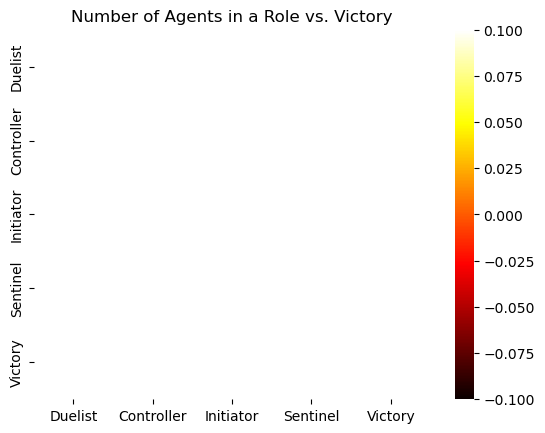

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = modeldf[["Duelist", "Controller", "Initiator","Sentinel","Victory"]].corr()
print(correlation_matrix)


# Visualize with heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="hot", fmt=".2f")
plt.title("Number of Agents in a Role vs. Victory")
plt.show()


ValueError: Axis limits cannot be NaN or Inf

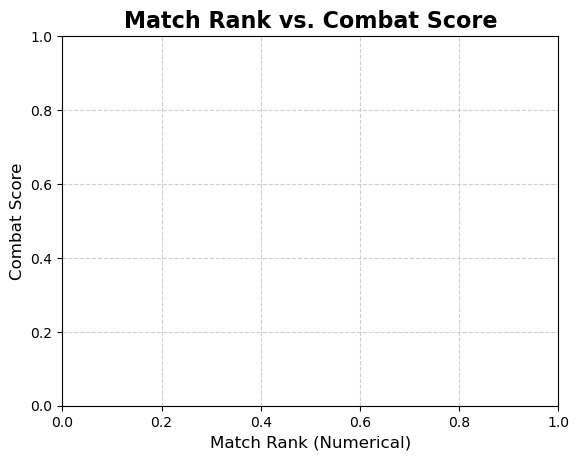

In [ ]:

sns.stripplot(data=pdata,
                x="MatchRank",
                y="CombatScore",
                hue = "MatchRank",
                palette="viridis",
                s=5,
                edgecolor ="w",
                jitter = True)

plt.title("Match Rank vs. Combat Score", fontsize=16, weight='bold')
plt.xlabel("Match Rank (Numerical)", fontsize=12)
plt.ylabel("Combat Score", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(pdata["MatchRank"].min() - 1.5, pdata["MatchRank"].max() + 0.5)
plt.ylim(pdata["CombatScore"].min() - 10, pdata["CombatScore"].max() + 10)

plt.show()

